# Import Packages and Define Utility Functions

In [2]:
%env MUJOCO_GL=egl

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

from dm_control import composer
from dm_control import mujoco
from dm_control.utils import inverse_kinematics as ik
from IPython.display import HTML

%matplotlib widget

def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

env: MUJOCO_GL=egl


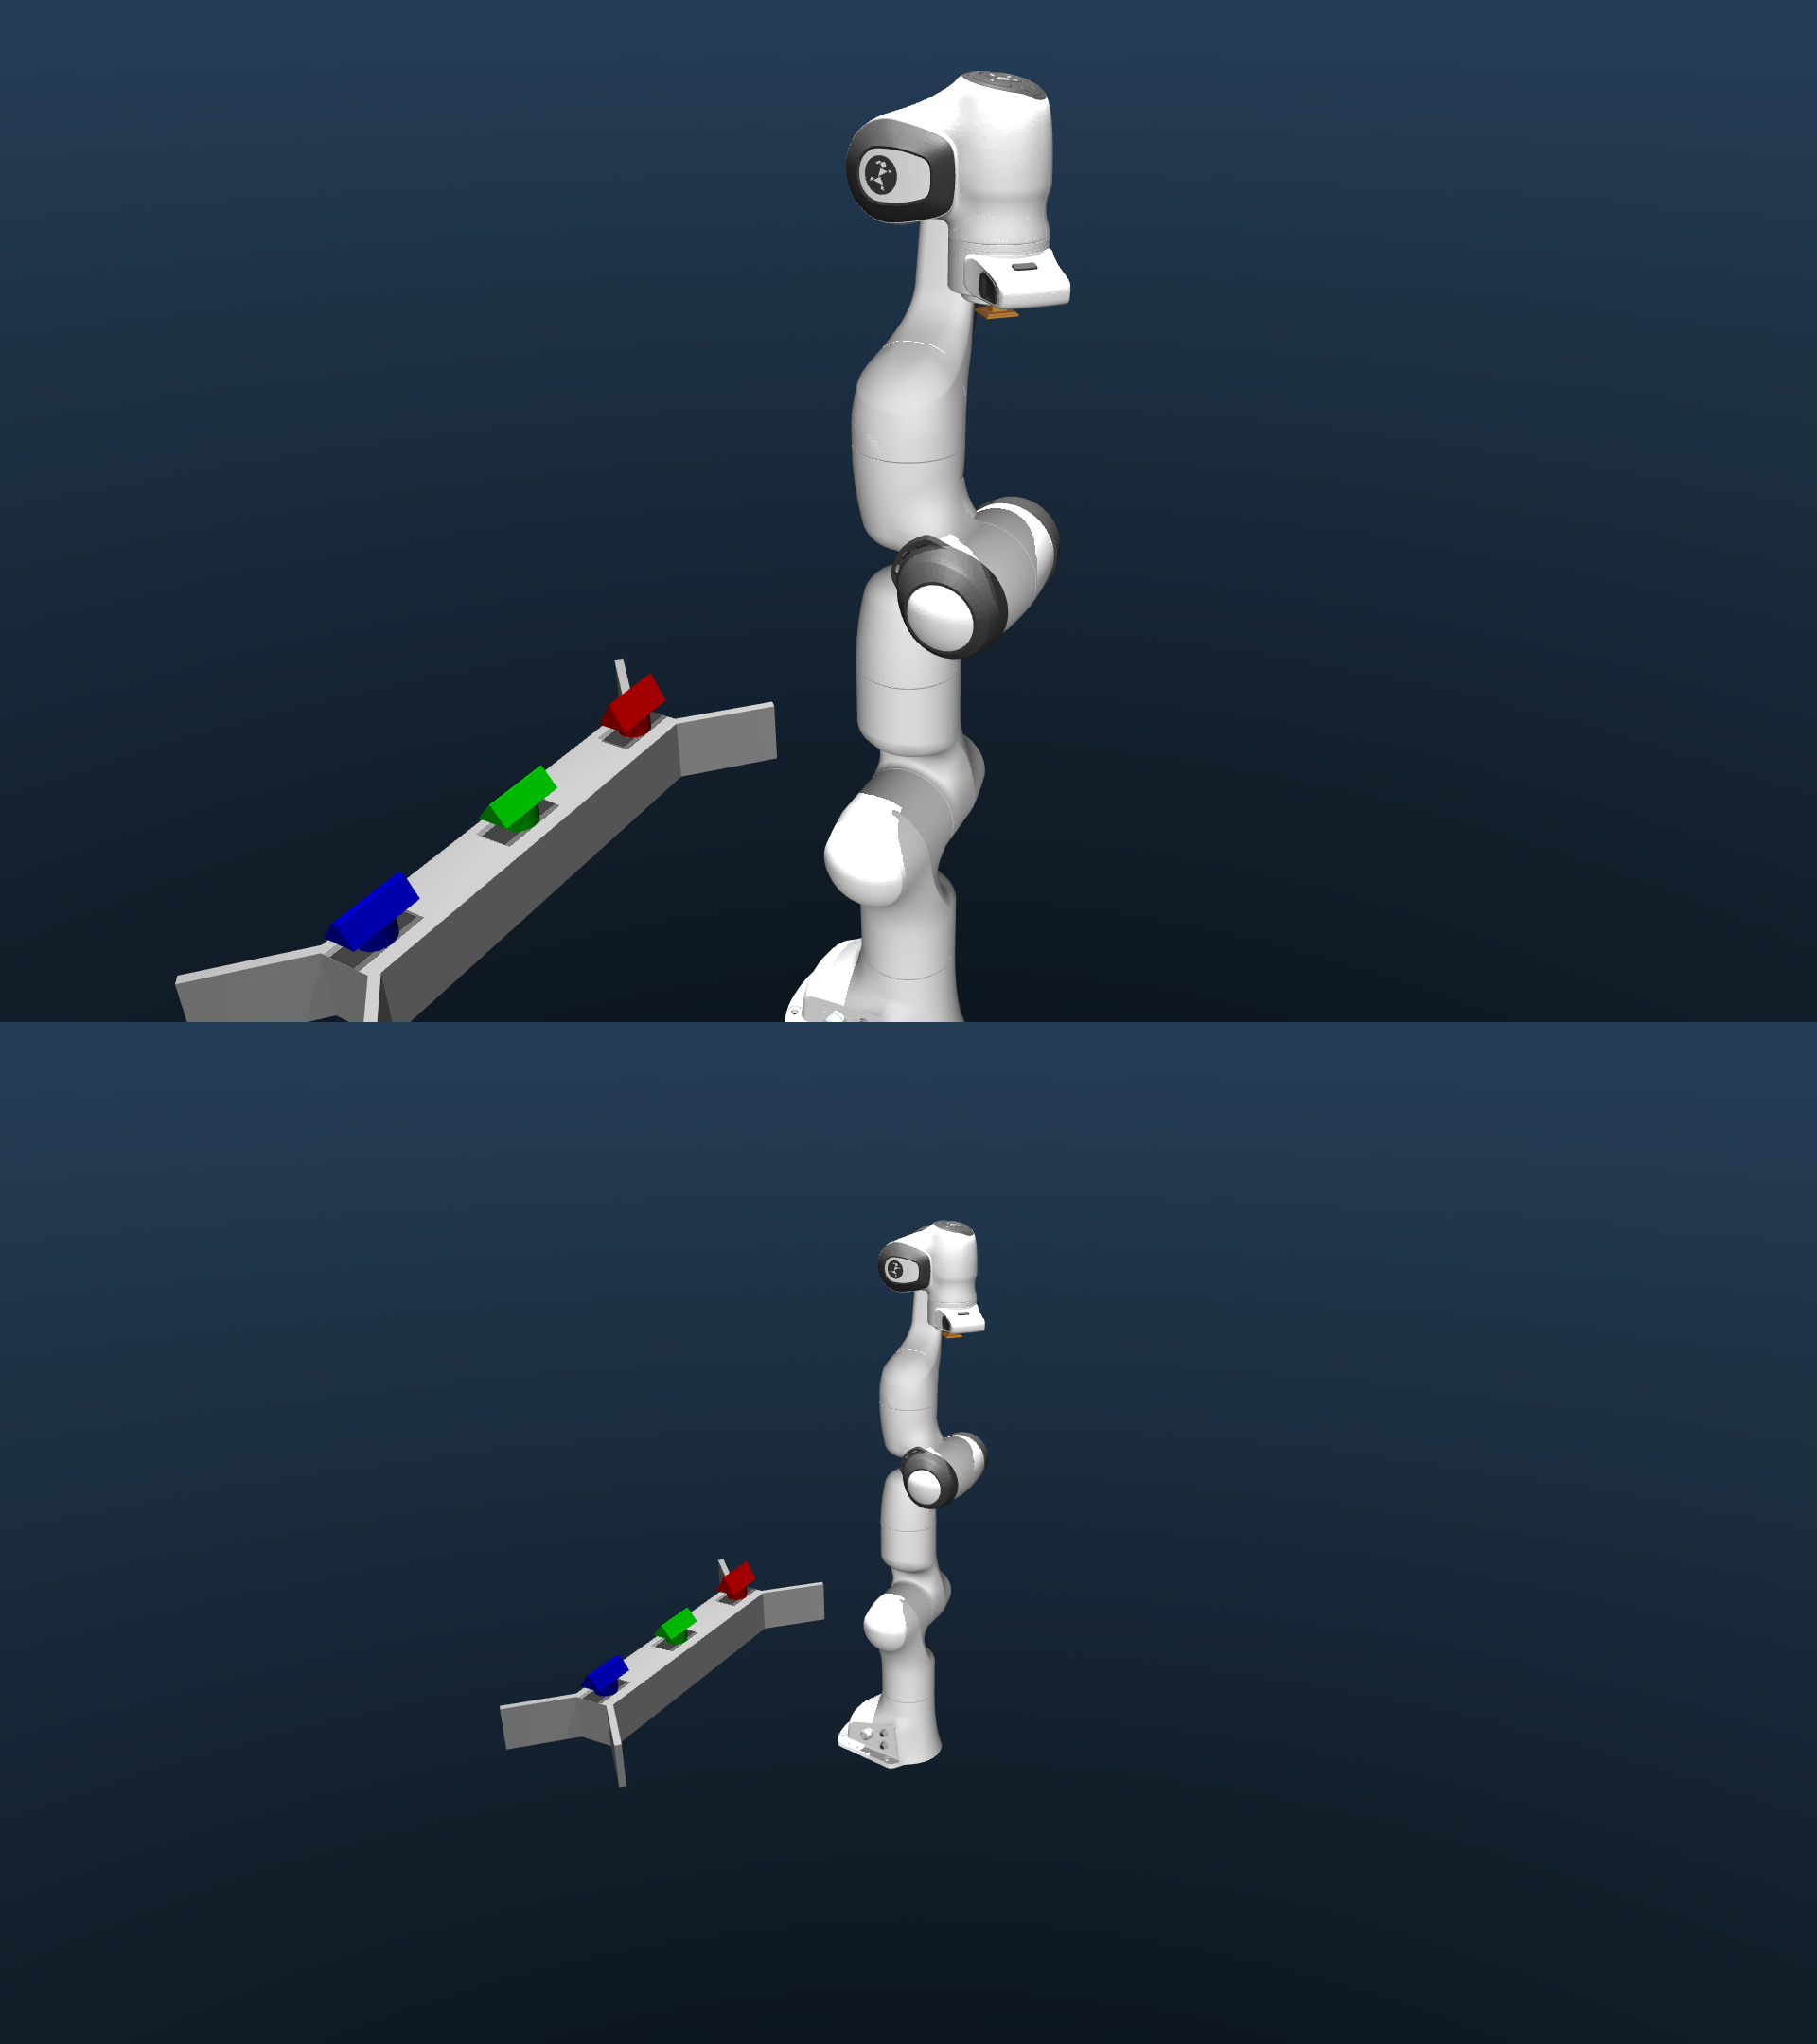

In [78]:
# IK solver parameters
_MAX_STEPS = 100
_TOL = 1e-12

scene_xml = 'models/scene.xml'
site_name = 'attachment_site'

physics = mujoco.Physics.from_xml_path(scene_xml)
target_pos = physics.named.data.site_xpos[site_name]

"""
result = ik.qpos_from_site_pose(
          physics=physics,
          site_name=site_name,
          target_pos=target_pos,
          #target_quat=target_quat,
          joint_names=joint_names,
          tol=_TOL,
          max_steps=_MAX_STEPS,
          inplace=True,
      )
"""

N = 2 # Number of cameras
random_state = np.random.RandomState(1024)
pixels = []
cameras = random_state.choice(physics.model.ncam, N, replace=False)
for camera_id in cameras:
    pixels.append(physics.render(camera_id=camera_id, width=1920, height=1080))
image = np.vstack((np.hstack(pixels[:N-1]), np.hstack(pixels[N-1:])))
PIL.Image.fromarray(image)

In [83]:
duration = 5.0 # (Seconds)
framerate = 24  # (Hz)
video = []

# Simulate, saving video frames
physics.reset()
time = 0.0
s = 1
ctrl = np.zeros(10)
while physics.data.time < duration:
    # Inject controls and step the physics.
    ctrl+=np.pi*2/(duration*framerate)
    physics.set_control(ctrl)
    physics.step()

    # Save video frames.
    if len(video) < physics.data.time * framerate:
        pixels = physics.render(camera_id='prospective', width=1920, height=1080)
        video.append(pixels.copy())

display_video(video, framerate)

<_MjContactList
  H: array([], shape=(0, 36), dtype=float64)
  dim: array([], dtype=int32)
  dist: array([], dtype=float64)
  efc_address: array([], dtype=int32)
  exclude: array([], dtype=int32)
  frame: array([], shape=(0, 9), dtype=float64)
  friction: array([], shape=(0, 5), dtype=float64)
  geom1: array([], dtype=int32)
  geom2: array([], dtype=int32)
  includemargin: array([], dtype=float64)
  mu: array([], dtype=float64)
  pos: array([], shape=(0, 3), dtype=float64)
  solimp: array([], shape=(0, 5), dtype=float64)
  solref: array([], shape=(0, 2), dtype=float64)
>
<_MjContactList
  H: array([], shape=(0, 36), dtype=float64)
  dim: array([], dtype=int32)
  dist: array([], dtype=float64)
  efc_address: array([], dtype=int32)
  exclude: array([], dtype=int32)
  frame: array([], shape=(0, 9), dtype=float64)
  friction: array([], shape=(0, 5), dtype=float64)
  geom1: array([], dtype=int32)
  geom2: array([], dtype=int32)
  includemargin: array([], dtype=float64)
  mu: array([], dtype

KeyboardInterrupt: 

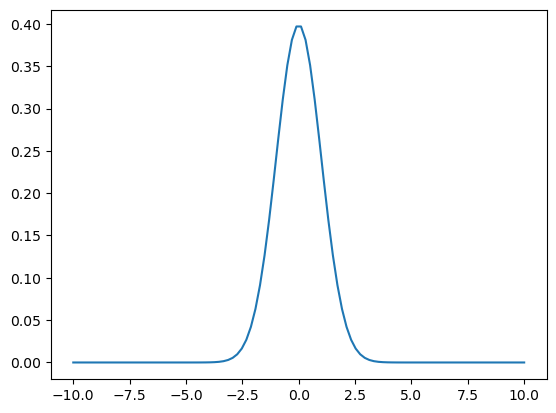

In [11]:
from scipy.stats import norm
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 100)
y1 = norm.pdf(x)
y2 = norm.pdf(2, 0.5, x)
plt.plot(x, y1)
plt.show()